In [1]:
import os
import time
import numpy as np
import pandas as pd

import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense
     
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization

from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
! for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

tee: '/sys/bus/pci/devices/0000:00:00.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:01.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:01.3/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:03.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:04.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:05.0/numa_node': Read-only file system
0
tee: '/sys/bus/pci/devices/0000:00:06.0/numa_node': Read-only file system
0


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/button-tone-sz/columnLabels.csv
/kaggle/input/button-tone-sz/ERPdata.csv
/kaggle/input/button-tone-sz/demographic.csv
/kaggle/input/button-tone-sz/time.csv
/kaggle/input/button-tone-sz/mergedTrialData.csv
/kaggle/input/button-tone-sz/18.csv/18.csv
/kaggle/input/button-tone-sz/20.csv/20.csv
/kaggle/input/button-tone-sz/71.csv/71.csv
/kaggle/input/button-tone-sz/74.csv/74.csv
/kaggle/input/button-tone-sz/1.csv/1.csv
/kaggle/input/button-tone-sz/24.csv/24.csv
/kaggle/input/button-tone-sz/78.csv/78.csv
/kaggle/input/button-tone-sz/75.csv/75.csv
/kaggle/input/button-tone-sz/11.csv/11.csv
/kaggle/input/button-tone-sz/17.csv/17.csv
/kaggle/input/button-tone-sz/77.csv/77.csv
/kaggle/input/button-tone-sz/16.csv/16.csv
/kaggle/input/button-tone-sz/68.csv/68.csv
/kaggle/input/button-tone-sz/3.csv/3.csv
/kaggle/input/button-tone-sz/19.csv/19.csv
/kaggle/input/button-tone-sz/73.csv/73.csv
/kaggle/input/button-tone-sz/5.csv/5.csv
/kaggle/input/button-tone-sz/2.csv/2.csv
/kaggle/input/b

In [3]:
demographic = pd.read_csv("/kaggle/input/button-tone-sz/demographic.csv")
demographic

,subject,group,gender,age,education
0,1,0,M,44,16.0
1,2,0,M,39,17.0
2,3,0,M,53,18.0
3,4,0,M,52,15.0
4,5,0,M,41,16.0
...,...,...,...,...,...
76,77,1,M,28,13.0
77,78,1,F,32,16.0
78,79,1,M,37,16.0
79,80,1,M,33,13.0


In [4]:
demographic[" group"].mean()

0.6049382716049383

In [5]:
demographic[" group"].value_counts()

1    49
0    32
Name:  group, dtype: int64

In [6]:
for i, t in enumerate(list(demographic[" group"])):
    if t:
        print(f"{i} - Schizophrenia")
    else:
        print(f"{i} - HEALTHY")
        

0 - HEALTHY
1 - HEALTHY
2 - HEALTHY
3 - HEALTHY
4 - HEALTHY
5 - HEALTHY
6 - HEALTHY
7 - HEALTHY
8 - HEALTHY
9 - HEALTHY
10 - HEALTHY
11 - HEALTHY
12 - HEALTHY
13 - HEALTHY
14 - HEALTHY
15 - HEALTHY
16 - HEALTHY
17 - HEALTHY
18 - HEALTHY
19 - HEALTHY
20 - HEALTHY
21 - HEALTHY
22 - HEALTHY
23 - HEALTHY
24 - Schizophrenia
25 - Schizophrenia
26 - Schizophrenia
27 - Schizophrenia
28 - Schizophrenia
29 - Schizophrenia
30 - Schizophrenia
31 - Schizophrenia
32 - Schizophrenia
33 - Schizophrenia
34 - Schizophrenia
35 - Schizophrenia
36 - Schizophrenia
37 - Schizophrenia
38 - Schizophrenia
39 - Schizophrenia
40 - Schizophrenia
41 - Schizophrenia
42 - Schizophrenia
43 - Schizophrenia
44 - Schizophrenia
45 - Schizophrenia
46 - Schizophrenia
47 - Schizophrenia
48 - Schizophrenia
49 - Schizophrenia
50 - Schizophrenia
51 - Schizophrenia
52 - Schizophrenia
53 - Schizophrenia
54 - Schizophrenia
55 - Schizophrenia
56 - Schizophrenia
57 - Schizophrenia
58 - HEALTHY
59 - HEALTHY
60 - HEALTHY
61 - HEALTHY


In [7]:
diagnosis_dict = dict(zip(demographic.subject, demographic[" group"]))
del demographic

In [8]:
electrodes_list = list(pd.read_csv("/kaggle/input/button-tone-sz/columnLabels.csv").columns[4:])
print("Electrodes List \n",electrodes_list)

Electrodes List 
 ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'VEOa', 'VEOb', 'HEOL', 'HEOR', 'Nose', 'TP10']


In [9]:
def averaged_by_N_rows(a, n):
    """ 
    A function that averages n rows in a matrix
    """
    shape = a.shape
    assert len(shape) == 2
    assert shape[0] % n == 0
    b = a.reshape(shape[0] // n, n, 
                  shape[1])
    mean_vec = b.mean(axis=1)
    return mean_vec
    

In [10]:
N_AVERAGED = 16
X = np.zeros((81 * 100,  9216 * len(electrodes_list) // N_AVERAGED), dtype="float32")
Y = np.zeros(len(X))

part1_path = "../input/button-tone-sz"
part2_path = "../input/buttontonesz2"

# We pull out only those experiments where there were 9216 measurements (most often named so many times)
x_counter = 0
column_list = pd.read_csv("/kaggle/input/button-tone-sz/columnLabels.csv").columns
for person_number in tqdm(range(1, 81 + 1)):


    csv_path = f"{part1_path}/{person_number}.csv/{person_number}.csv"
    if not os.path.exists(csv_path):
        csv_path = f"{part2_path}/{person_number}.csv/{person_number}.csv"
    df = pd.read_csv(csv_path, 
                header=None,
                names=column_list)
    trials_list = set(df.trial)

    

    for t1, trial_number in enumerate(trials_list):
        number_of_trials = len(df[df.trial == trial_number])
        if number_of_trials == 9216.0:
            current_sample_matrix = df[df.trial == trial_number][electrodes_list].values
            averaged_by_N = averaged_by_N_rows(current_sample_matrix, n=N_AVERAGED)
            averaged_by_N_big_vec = averaged_by_N.reshape(-1)
            X[x_counter] = averaged_by_N_big_vec.astype(np.float32)
            Y[x_counter] = diagnosis_dict[person_number]
            x_counter += 1
print("Total trials with the Appropriate number of measurements - ", x_counter)
X = X[: x_counter]
Y = Y[: x_counter]
        
print("Total trials with the Appropriate number of measurements- ", x_counter)

  0%|          | 0/81 [00:00<?, ?it/s]

Total trials with the Appropriate number of measurements -  7092
Total trials with the Appropriate number of measurements-  7092


In [11]:
X.shape

(7092, 40320)

In [12]:
Y.shape

(7092,)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

In [14]:
X_norm = (normalize(X.reshape(-1, 70), axis=0, norm='max')).reshape(X.shape)

In [15]:
X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(X_norm, Y, test_size=0.2, shuffle=True, random_state=42)

In [16]:
_norm = X

In [17]:
X_train_2d = X_train_norm.reshape(X_train_norm.shape[0], len(electrodes_list), X_train_norm.shape[1] // len(electrodes_list), 1)
X_test_2d = X_test_norm.reshape(X_test_norm.shape[0], len(electrodes_list), X_test_norm.shape[1] // len(electrodes_list), 1)

In [18]:
filepath="/kaggle/working/best_model1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 20),
                 activation='tanh',
                 input_shape=(X_train_2d.shape[1:])))
model.add(MaxPooling2D(pool_size=(5, 15)))

model.add(Conv2D(13, kernel_size=(3, 3),
                 activation='tanh',))
model.add(MaxPooling2D(pool_size=(3, 3)))
          

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(317, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [19]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.optimizers.Adam(0.000008),
              metrics=['acc'])

In [20]:
history_params = []

In [21]:

history = model.fit(X_train_2d, Y_train_norm,
          batch_size=17,
          epochs=100,
          verbose=1,
          shuffle=True,
          validation_data=(X_test_2d, Y_test_norm), callbacks=[checkpoint])

Epoch 1/100
334/334 [==============================] - 11s 10ms/step - loss: 0.6847 - acc: 0.5822 - val_loss: 0.6768 - val_acc: 0.5927

Epoch 00001: val_acc improved from -inf to 0.59267, saving model to /kaggle/working/best_model1.h5
Epoch 2/100
334/334 [==============================] - 3s 8ms/step - loss: 0.6708 - acc: 0.5983 - val_loss: 0.6706 - val_acc: 0.5927

Epoch 00002: val_acc did not improve from 0.59267
Epoch 3/100
334/334 [==============================] - 3s 8ms/step - loss: 0.6673 - acc: 0.5983 - val_loss: 0.6701 - val_acc: 0.5927

Epoch 00003: val_acc did not improve from 0.59267
Epoch 4/100
334/334 [==============================] - 3s 8ms/step - loss: 0.6664 - acc: 0.5983 - val_loss: 0.6702 - val_acc: 0.5927

Epoch 00004: val_acc did not improve from 0.59267
Epoch 5/100
334/334 [==============================] - 3s 8ms/step - loss: 0.6657 - acc: 0.5983 - val_loss: 0.6697 - val_acc: 0.5927

Epoch 00005: val_acc did not improve from 0.59267
Epoch 6/100
334/334 [========

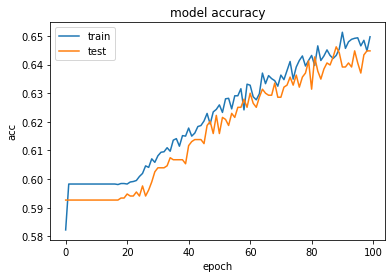

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

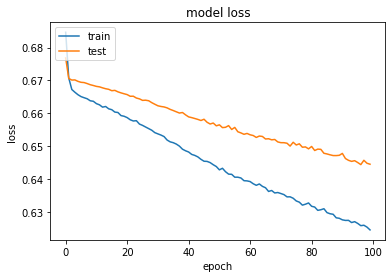

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
accuracy, loss = model.evaluate(X_test_2d, Y_test_norm)
print(f"Val accuracy={accuracy}  val loss={loss}")

45/45 [==============================] - 0s 6ms/step - loss: 0.6445 - acc: 0.6448
Val accuracy=0.6445469260215759  val loss=0.6448202729225159


In [ ]:
y_predicted =  model.predict(X_test_2d)

confusion_matr = confusion_matrix(Y_test_norm, np.round(model.predict(X_test_2d)))
confusion_matr

In [ ]:
print(
    "True Positive for schizophrenia ", confusion_matr[0, 0], "\n",
    "False Positive for schizophrenia ", confusion_matr[0, 1], "\n",
    "False Neagtive For Healthy ", confusion_matr[1, 0], "\n",
    "True Neagtive For Healthy ", confusion_matr[1, 1], "\n")

In [ ]:
TP = confusion_matr[0, 0]
FP = confusion_matr[0, 1]
FN = confusion_matr[1, 0]
TN = confusion_matr[1, 1]
TP, FP, FN, TN

### <span style="color:#e76f51;">Sensitivity for the first network</span>

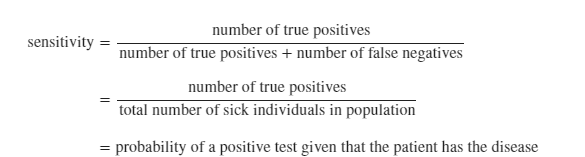

In [ ]:
sensitivity = TP / (TP + FN)
sensitivity

### <span style="color:#e76f51;">Specificity for the first network</span>

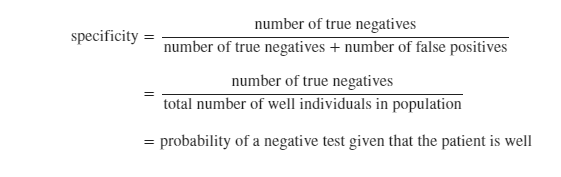

In [ ]:
specificity = TN / (TN + FP)
specificity

### <span style="color:#e76f51;">Fully Connected Neural Network (Model 2)</span>

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
filepath="/kaggle/working/best_model2.h5" # Checkpoints
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# Simple Neural Networks with 5000 Neurons
model_2 = Sequential()
model_2.add(Dense(5000,
                  activation='relu',
                  input_shape=(X_train.shape[1:])))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(loss=keras.losses.binary_crossentropy,
               optimizer=tf.optimizers.Adam(0.000008),
               metrics=['acc'])

In [ ]:
history_params_2 = []
history_2 = model_2.fit(X_train, Y_train,
          batch_size=17,
          epochs=100,
          verbose=1,
          shuffle=True,
          validation_data=(X_test, Y_test), callbacks=[checkpoint])

In [ ]:
loss, accuracy = model_2.evaluate(X_test, Y_test)
loss, accuracy 

## <span style="color:#e76f51;">Summarize History For Accuracy And Loss For Second Network</span>

In [ ]:
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <span style="color:#e76f51;">Confusion matrix</span>

In [ ]:
y_predicted =  model_2.predict(X_test)

confusion_matr = confusion_matrix(Y_test, np.round(model_2.predict(X_test)))
confusion_matr

In [ ]:
print(
 "True Positive for schizophrenia ", confusion_matr[0, 0], "\n",
 "False Positive for schizophrenia ", confusion_matr[0, 1], "\n",
 "False Neagtive For Healthy ", confusion_matr[1, 0], "\n",
 "True Neagtive For Healthy ", confusion_matr[1, 1], "\n"    
)

In [ ]:
TP = confusion_matr[0, 0]
FP = confusion_matr[0, 1]
FN = confusion_matr[1, 0]
TN = confusion_matr[1, 1]
TP, FP, FN, TN

### <span style="color:#e76f51;">Sensitivity for the Second network</span>

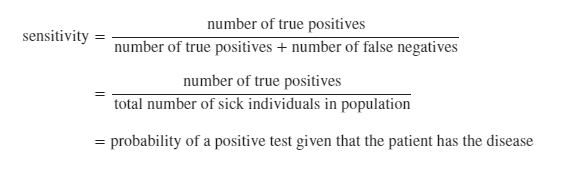

In [ ]:
sensitivity = TP / (TP + FN)
sensitivity

### <span style="color:#e76f51;">Specificity for the Second network</span>

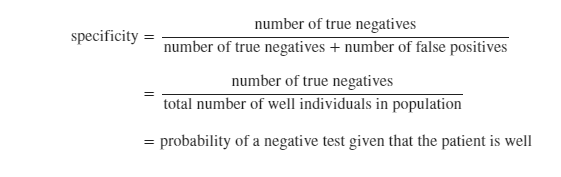

In [ ]:
specificity = TN / (TN + FP)
specificity

### **<span style="color:#e76f51;">Acknowledgements</span>**

- [EEG data from basic sensory task in Schizophrenia](https://www.kaggle.com/datasets/broach/button-tone-sz)

- [Did I Do That? Abnormal Predictive Processes in Schizophrenia When Button Pressing to Deliver a Tone](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4059422/)

- https://www.kaggle.com/broach/buttontonesz2

### **<span style="color:#e76f51;">Attributions</span>**

- [FASTER: Fully Automated Statistical Thresholding for EEG artifact Rejection](https://pubmed.ncbi.nlm.nih.gov/20654646/)

- [A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

- [An Introduction to Convolutional Neural Networks](https://arxiv.org/abs/1511.08458)

- [Recent Advances in Convolutional Neural Networks](https://arxiv.org/abs/1512.07108)

- [CodeBasics YouTube](https://www.youtube.com/watch?v=zfiSAzpy9NM)


## Work in progress 🚧

# Do Comments For Question and Queries

<center><h1 style = "font-size:25px;font-family: Comic Sans MS"> Please do upvote as I put lots of hard work in this. Also feel free to comment if you have any queries:)</h1></center>